In [561]:
import os
import pandas as pd
from datetime import datetime
import time
import math
import numpy as np
import networkx as nx
import copy
import random
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'C:\\Users\\Vojta\\Desktop\\own\\university\\ing\\01\\madII_projects\\analysis'

In [3]:
name_of_file = 'ia-retweet-pol.edges'

In [4]:
path_to_file = f'.\\ds\\{name_of_file}'

In [5]:
!pip install pandas

  Using cached https://files.pythonhosted.org/packages/b9/b9/6a13093ca4e4ea11af84fd40076601397f725944add620937f27319a940b/pandas-1.2.4-cp38-cp38-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/70/94/784178ca5dd892a98f113cdd923372024dc04b8d40abe77ca76b5fb90ca6/pytz-2021.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/89/c3/a0fa36e9fea68f782d3ce5eba4187d090ec81db035e356c8046713b22a1f/numpy-1.20.2-cp38-cp38-win_amd64.whl


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [12]:
dataset = pd.read_csv(path_to_file, sep=',', header=None)

In [13]:
dataset.head()

,0,1,2
0,12464,7349,1286901355
1,6820,12569,1287988962
2,4336,15967,1286535938
3,16397,5927,1285134188
4,8829,13851,1285493596


In [21]:
dataset['converted_time'] = dataset.iloc[:, 2].apply(time.ctime)

In [22]:
dataset.head()

,0,1,2,converted_time
0,12464,7349,1286901355,Tue Oct 12 18:35:55 2010
1,6820,12569,1287988962,Mon Oct 25 08:42:42 2010
2,4336,15967,1286535938,Fri Oct 8 13:05:38 2010
3,16397,5927,1285134188,Wed Sep 22 07:43:08 2010
4,8829,13851,1285493596,Sun Sep 26 11:33:16 2010


In [31]:
dataset = dataset.sort_values(by=2)

In [162]:
dataset.head()

,0,1,2,converted_time
60312,12464,1266,1284436821,Tue Sep 14 06:00:21 2010
33870,1864,11180,1284436868,Tue Sep 14 06:01:08 2010
23251,10488,7720,1284436924,Tue Sep 14 06:02:04 2010
23641,9408,9682,1284437061,Tue Sep 14 06:04:21 2010
5005,12750,12317,1284437161,Tue Sep 14 06:06:01 2010


In [163]:
START_UNIX = 1284436821

In [164]:
first = dataset.iloc[0]
first.converted_time

'Tue Sep 14 06:00:21 2010'

In [165]:
last = dataset.iloc[-1]
last.converted_time

'Mon Nov  1 23:41:59 2010'

In [166]:
NUMBER_OF_LAYERS = 3

In [167]:
interval = last[2] - first[2]

In [168]:
interval

4214498

In [169]:
size = math.ceil(interval / NUMBER_OF_LAYERS)

In [170]:
size

1404833

In [171]:
START_UNIX + size * 3

1288651320

In [172]:
last[2]

1288651319

In [173]:
def create_sub_df(step, index, last_end_index, data, last=False):
    end_value = START_UNIX + index * step
    time_values = data.iloc[:, 2].values

    if last:
        print('end')
        f_i = int(last_end_index) #from index
        sub_df = data.iloc[f_i:, :]
        return sub_df, None
        
    
    
    find_value = end_value
    v = None
    while True:
        v = np.argwhere(time_values == find_value).flatten()
        
        if(len(v) > 0):
            print(v)
            print('Found')
            
            break
        find_value -= 1

    f_i = int(last_end_index) #from index
    t_i = int(v[-1] + 1) #to index 

    sub_df = data.iloc[f_i:t_i, :]
    my_end_index = t_i
    return sub_df, my_end_index

In [174]:
sub_dfs = []
last_end_index = 0
for i in range(NUMBER_OF_LAYERS):
    transformed_i = i + 1
    sub_df, last_end_index = create_sub_df(size, transformed_i, last_end_index, dataset, transformed_i==NUMBER_OF_LAYERS)
    sub_dfs.append(sub_df)

[20622]
Found
[40794]
Found
end


In [175]:
len(sub_dfs)

3

# Check len

In [176]:
for i in range(len(sub_dfs)):
    sub_len = len(sub_dfs[i])
    print(f'DF{i} - {sub_len}')

DF0 - 20623
DF1 - 20172
DF2 - 20362


In [177]:
len(dataset) == np.sum([len(df) for df in sub_dfs]) #correct multilayer

True

In [178]:
def from_df_g(sub_df):
    G = nx.from_pandas_edgelist(sub_df, 0, 1)
    return G

In [179]:
#Gs without appended nodes
Gs = []

In [180]:
nodes_ids_1 = dataset.iloc[:, 0]
nodes_ids_2 = dataset.iloc[:, 1]


nodes_ids = np.unique(np.array(list(np.unique(nodes_ids_1)) +  list(np.unique(nodes_ids_2))))

In [181]:
for s_df in sub_dfs:
    s_G = from_df_g(s_df)
    Gs.append(s_G)

In [182]:
Gs_appended = Gs.copy()

In [183]:
#append not existing actors to Gs
for current_G in Gs_appended:
    current_nodes = current_G.nodes() 
    need_to_append = list(filter(lambda x: x not in current_nodes, nodes_ids)) 

    for node_to_append in need_to_append:
        current_G.add_node(node_to_append)

In [184]:
UNIQUE_NODES = (len(nodes_ids))
print(UNIQUE_NODES)

18470


In [185]:
Gs_len = np.sum([len(g.nodes()) for g in Gs])
print(Gs_len)

55410


In [186]:
Gs_len_appended = np.sum([len(g.nodes()) for g in Gs_appended]) 
print(Gs_len_appended)

55410


In [187]:
labels = list(Gs[0].nodes())

In [188]:
sub_dfs[0]

,0,1,2,converted_time
60312,12464,1266,1284436821,Tue Sep 14 06:00:21 2010
33870,1864,11180,1284436868,Tue Sep 14 06:01:08 2010
23251,10488,7720,1284436924,Tue Sep 14 06:02:04 2010
23641,9408,9682,1284437061,Tue Sep 14 06:04:21 2010
5005,12750,12317,1284437161,Tue Sep 14 06:06:01 2010
...,...,...,...,...
4117,10396,12484,1285841066,Thu Sep 30 12:04:26 2010
33276,15365,3668,1285841077,Thu Sep 30 12:04:37 2010
40004,6533,17339,1285841329,Thu Sep 30 12:08:49 2010
47240,13300,7239,1285841430,Thu Sep 30 12:10:30 2010


In [262]:
LAYER_LABELS = []

for i in range(NUMBER_OF_LAYERS):
    current_df = sub_dfs[i]
    start = current_df.iloc[0]
    end = current_df.iloc[-1]
  

    WORD_TITLE = f'Od {start.converted_time} - Do {end.converted_time}'
    print(WORD_TITLE)
    start_string = start.converted_time.replace(' ', '_').replace(':', '_')
    end_string = end.converted_time.replace(' ', '_').replace(':', '_')
    
    
    
    print(start_string)
    print(end_string)
    layer_name = f'{start_string}---{end_string}'
    LAYER_LABELS.append(layer_name)
    


Od Tue Sep 14 06:00:21 2010 - Do Thu Sep 30 12:11:38 2010
Tue_Sep_14_06_00_21_2010
Thu_Sep_30_12_11_38_2010
Od Thu Sep 30 12:14:36 2010 - Do Sat Oct 16 18:27:49 2010
Thu_Sep_30_12_14_36_2010
Sat_Oct_16_18_27_49_2010
Od Sat Oct 16 18:29:15 2010 - Do Mon Nov  1 23:41:59 2010
Sat_Oct_16_18_29_15_2010
Mon_Nov__1_23_41_59_2010


In [254]:
LAYER_LABELS

['Tue_Sep_14_06_00_21_2010---Thu_Sep_30_12_11_38_2010',
 'Thu_Sep_30_12_14_36_2010---Sat_Oct_16_18_27_49_2010',
 'Sat_Oct_16_18_29_15_2010---Mon_Nov__1_23_41_59_2010']

# Save gephi

In [255]:
PATH_TO_GEPHI = f'outputs\\gephi\\'

In [256]:
os.getcwd() + PATH_TO_GEPHI

'C:\\Users\\Vojta\\Desktop\\own\\university\\ing\\01\\madII_projects\\analysisoutputs\\gephi\\'

In [257]:
SAVE_GRAPHS = True

In [259]:
if SAVE_GRAPHS:
    for i, G in enumerate(Gs):
        name = LAYER_LABELS[i]
        path = f'{PATH_TO_GEPHI}GRAPH{i}_{name}.gexf'
        print(path)
        nx.write_gexf(G, path)

outputs\gephi\GRAPH0_Tue_Sep_14_06_00_21_2010---Thu_Sep_30_12_11_38_2010.gexf
outputs\gephi\GRAPH1_Thu_Sep_30_12_14_36_2010---Sat_Oct_16_18_27_49_2010.gexf
outputs\gephi\GRAPH2_Sat_Oct_16_18_29_15_2010---Mon_Nov__1_23_41_59_2010.gexf


In [269]:
from enum import Enum
class Properties(Enum):
    V_L = 'Počet vrcholů' #
    N_L = 'Počet hran' #
    HUSTOTA = 'Hustota'
    AVG_D = 'Průměrný stupeň' #
    MAX_D = 'Maximální stupeň' #
    DIS_D = 'Distribuce stupňů' #
    AVG_COEF = 'Průměrný shlukovací koeficient' #
    CC_L = 'Počet komponent souvislosti' #
    DIST_CC = 'Distribuce velikostí komponent' #


In [277]:
from collections import Counter

# Analysis function

In [327]:
def run_analysis(G):
    result = {}
    n = len(G.nodes())
    m = len(G.edges())
    
    _, degress = zip(*G.degree())
    c = Counter(degress)    
    sorted_degress = dict(sorted(c.items(), key=lambda item: item[0]))
    
    cc = list(nx.connected_components(G))
    len_cc = [len(c) for c in cc] 
    number_of_cc = len(cc)
    
    c1 = Counter(len_cc)
    sorted_cc = dict(sorted(c1.items(), key=lambda item: item[0]))
    
    
    result[Properties.V_L.value] = n
    result[Properties.N_L.value] = m
    #TODO hustota
    result[Properties.AVG_D.value] = (2*m) / n
    result[Properties.MAX_D.value] = np.max(degress)
    result[Properties.DIS_D.value] = sorted_degress
    
    result[Properties.CC_L.value] = number_of_cc
    result[Properties.DIST_CC.value] = sorted_cc
    
    result[Properties.AVG_COEF.value] = nx.average_clustering(G)

    return result
    

    
    

# Run analysis for graphs

In [328]:
analysis_dic = {}
for i, g in enumerate(Gs):
    analysis_dic[i] = run_analysis(g)

# And save everything to file :-)

In [503]:
def make_distribution_graph(distribution_input, name='', scatter=False):
    x, y = zip(*distribution_input.items())
    
    
    fig, ax = plt.subplots()
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Size')
    
    ax.set_title(name)
    ax.set_xlim(0-10, np.max(x)+10)
    ax.set_ylim(0-10, np.max(y)+10)
    ax.grid()
    if scatter:

        ax.scatter(x, y, c='r')   
    else:   
        ax.bar(x, y, color='r', width=2)
    return fig, ax

In [493]:
def create_analysis_df(analysis, i):
    return pd.DataFrame.from_dict(analysis, orient='index', columns=['Strukturální vlastnosti'])

In [494]:
PATH_TO_EXCELS = f'outputs\\excels\\'

In [495]:
PATH_TO_GRAPHS = f'outputs\\graphs\\'

In [496]:
def save_graphs(graphs, index):
    graph_layer_folder = f'{PATH_TO_GRAPHS}{index}'
    if not os.path.exists(graph_layer_folder):
        os.makedirs(graph_layer_folder)
        
    for g_i, graph in enumerate(graphs):
        fig_ax, name = graph
        fig_ax[0].savefig(f'{graph_layer_folder}\\{name}.jpg') 

    

In [497]:
def normalize(arra):
    m = np.max(arra)
    return [item/m for item in arra]
    

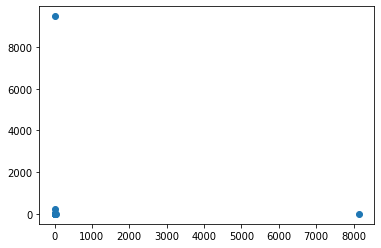

In [498]:
plt.scatter([1, 2, 3, 4, 5, 6, 7, 8, 15, 18, 34, 8142], [9469, 245, 52, 15, 9, 2, 3, 1, 1, 1, 1, 1])

y (9469, 245, 52, 15, 9, 2, 3, 1, 1, 1, 1, 1)
x (1, 2, 3, 4, 5, 6, 7, 8, 15, 18, 34, 8142)


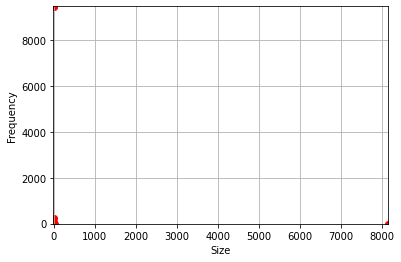

In [500]:
test = make_distribution_graph(analysis_dic[1][Properties.DIST_CC.value], '', True)

y (8600, 5998, 1350, 649, 378, 266, 166, 118, 131, 96, 61, 69, 47, 51, 43, 38, 37, 35, 21, 25, 17, 23, 12, 14, 17, 10, 13, 10, 15, 7, 4, 3, 8, 4, 7, 4, 6, 9, 6, 6, 2, 1, 5, 3, 2, 3, 5, 2, 5, 5, 2, 2, 2, 3, 1, 3, 4, 1, 1, 2, 1, 2, 1, 1, 2, 3, 1, 4, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
x (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 68, 69, 71, 72, 74, 76, 78, 79, 83, 84, 85, 86, 87, 94, 97, 108, 117, 122, 128, 132, 133, 134, 138, 144, 171, 196, 223, 757)
y (8600, 241, 44, 22, 5, 2, 2, 1, 1, 2, 1, 1)
x (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 21, 9059)
y (9469, 5021, 1370, 649, 404, 246, 197, 165, 105, 97, 68, 62, 70, 58, 43, 32, 29, 41, 22, 26, 15, 19, 18, 10, 20, 14, 12, 13, 3, 13, 9, 14, 11, 5, 6, 5, 4, 4, 5, 7, 4, 1, 3, 4, 5, 4, 5, 1, 3, 3, 3, 1, 1, 4, 2

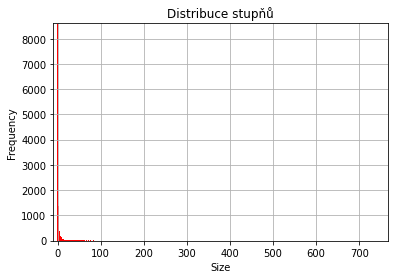

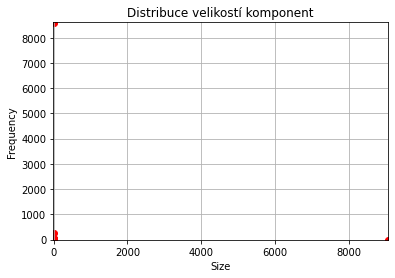

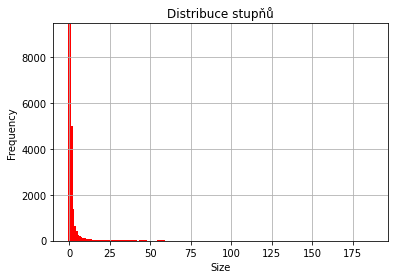

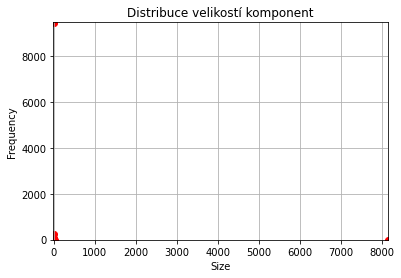

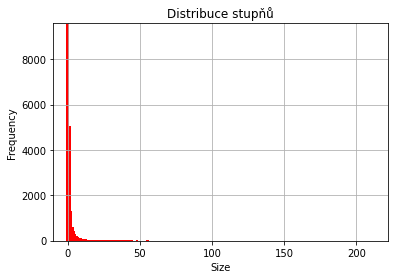

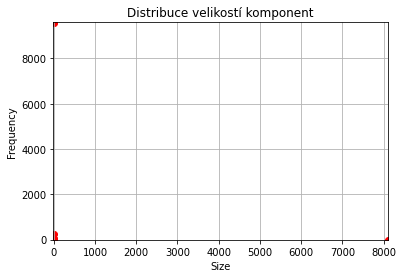

In [502]:
dfs = []
for k in analysis_dic.keys():
    df = create_analysis_df(analysis_dic[k], k)
    dist_degress = make_distribution_graph(analysis_dic[k][Properties.DIS_D.value], Properties.DIS_D.value)
    dist_cc = make_distribution_graph(analysis_dic[k][Properties.DIST_CC.value], Properties.DIST_CC.value, True)
    graphs = [(dist_degress, Properties.DIS_D.value), (dist_cc, Properties.DIST_CC.value)]
    save_graphs(graphs, k)
    dfs.append(df)
    
with pd.ExcelWriter(f'{PATH_TO_EXCELS}output.xlsx') as writer:  
    for i, df in enumerate(dfs):
        name = LAYER_LABELS[i]
        df.to_excel(writer, sheet_name=name)

In [521]:
PATH_TO_TOGETHER_GRAPHS = f'{PATH_TO_GRAPHS}\\together'

In [551]:
def get_cumulative(distribution_array):
    sizes, times = zip(*distribution_array.items())
    print(distribution_array)
    suma = np.sum(times)
    r_freq = [t/suma for t in times]
    sizes = list(sizes) + [sizes[-1] + 1]
    sizes = normalize(sizes)
    
    cum_freq = [0]
    for f_i, f_v in enumerate(r_freq[0:len(r_freq)]):
        cum_freq.append(cum_freq[f_i] + f_v)
        
    return sizes, cum_freq
    
    

In [559]:
#get_cumulative(analysis_dic[0][Properties.DIST_CC.value])

In [ ]:
def make_cumulative_distribution(analysis, key, true_names=False, save=True):
    fig, ax = plt.subplots()
    graph_title = f'Kumulativni {str(key).lower()}'
    ax.set_title(graph_title)
    ax.set_ylabel('Relative frequency')
    ax.set_xlabel('Normalized size')
    
    for k in analysis:
        name = LAYER_LABELS[k] if true_names else f'{k}'
        current_analysis = analysis[k]
        distribution_values = current_analysis[key]
        result = get_cumulative(distribution_values)
        ax.plot(*result, label=name)
        
      
    ax.legend()
    if save:
        fig.savefig(f'{PATH_TO_TOGETHER_GRAPHS}\\cumulative_freq_{str(key).lower()}.jpg') 
        
    return fig, ax
    
    
    

In [ ]:
make_cumulative_distribution(analysis_dic, Properties.DIS_D.value)

{1: 8600, 2: 241, 3: 44, 4: 22, 5: 5, 6: 2, 7: 2, 8: 1, 9: 1, 10: 2, 21: 1, 9059: 1}
{1: 9469, 2: 245, 3: 52, 4: 15, 5: 9, 6: 2, 7: 3, 8: 1, 15: 1, 18: 1, 34: 1, 8142: 1}
{1: 9580, 2: 240, 3: 38, 4: 19, 5: 7, 6: 4, 7: 2, 9: 1, 10: 2, 17: 1, 8101: 1}


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Kumulativni distribuce velikostí komponent'}, xlabel='Normalized size', ylabel='Relative frequency'>)

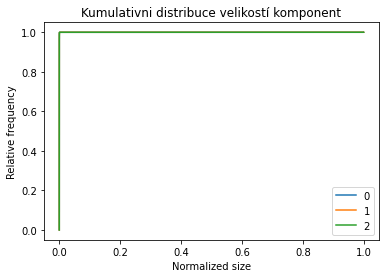

In [575]:
make_cumulative_distribution(analysis_dic, Properties.DIST_CC.value)

In [576]:
PATH_SAVE_MULTILAYER_PROPERTIES = f'outputs\\multilayer\\'

In [577]:
PATH_R_MULTINET_LIB_INPUT = f'outputs\\r\\'

In [578]:
NUMBER_OF_STEPS = 10 #random walk
NUMBER_OF_TIMES = 100 #random walk
MOVE_TO_LAYER = -99 #idk :D

In [592]:




class MultiLevelNet:
    def __init__(self, matrix, actors, layers, layers_name = None, calculate=False, lab=8):
        self.lab = lab
        size = int(len(matrix) / layers)
        self.number_of_layers = layers
        self.multi_net = self.create_matrix(matrix, layers)
        self.actors = actors
        self.aindex2actor = {i:actors[i] for i in range(len(actors))}
        self.layers_name = layers_name
        self.calculate = calculate

        if self.calculate:
            print('Running calculate section')
            self.df = self.calculate_res_dataframe()
            self.layer_df = self.calculate_layer_properties()
            self.save_df(self.df, 'multilayer.csv')
            self.save_df(self.layer_df, 'layer.csv')

    def calculate_layer_properties(self):
        d_result = {}
        for l in range(self.number_of_layers):
            l_n = self.layers_name[l]
            l_res = {}

            for i, a in enumerate(self.actors):
                l_a_d = self.degree_centrality(i, [l])
                excl_neig = self.exclusive_neighborhood(i, [l])
                excl_rel = self.exclusive_relevance(i, [l])
                l_res[self.aindex2actor[i]] = {'Degree': round(l_a_d, 3), 'Exclu. Nei': round(excl_neig, 3), 'Exclu. Rele': round(excl_rel, 3)} 
        
            d_result[l_n] = l_res


        properties = ['Degree','Exclu. Nei','Exclu. Rele']
        header = pd.MultiIndex.from_product([self.layers_name,
                                            properties],
                                            names=['Layer name','Property'])


        columns=['Degree deviation', 'Degree', 'Neighbors', 'Connective redudancy']
        data = np.zeros((len(self.actors), 3 * self.number_of_layers), dtype='uint8')

        for i, k_i in enumerate(d_result.keys()): #layers as key
            for j, prop in enumerate(properties):
                constructed_array = []
                for _, k_j in enumerate(d_result[k_i].keys()): #actors as key
                    value = d_result[k_i][k_j][prop]
                    constructed_array.append(value)
                position = i * len(properties) + j
                data[:, position] = constructed_array    
            
        df = pd.DataFrame(data, columns=header, index=self.actors)
        return df

    def exclusive_relevance(self, actor, L):
        nom = self.exclusive_neighborhood(actor, L)
        den = self.neighborhood_centrality(actor,self.generate_all())
        if den == 0:
            return 0
        return nom / den


    def calculate_res_dataframe(self):
        d_res = []
        d_c_res = []
        neighborhood_res = []
        redudancy_res = []

        for i, a in enumerate(self.actors):
            
            L = list(range(self.number_of_layers))
            d = self.degree_centrality(i, L)
            d_c = self.degree_deviation(i, L)
            neighborhood = self.neighborhood_centrality(i, L)
            redudancy = self.connective_redundancy(i, L)            



            d_res.append(d)
            d_c_res.append(round(d_c, 3))
            neighborhood_res.append(neighborhood)
            redudancy_res.append(round(redudancy, 3))


        columns=['Degree deviation', 'Degree', 'Neighbors', 'Connective redudancy']
        df = pd.DataFrame({columns[0]: d_c_res, columns[1]: d_res, columns[2]: neighborhood_res, columns[3]: redudancy_res},index=self.actors)
        return df

    def save_df(self, df, name):
        df.to_csv(f'{PATH_SAVE_MULTILAYER_PROPERTIES}{name}', sep=';')


    def create_matrix(self, matrix, layers):
        full_size = len(matrix)
        layer_size = int(full_size / layers)
        self.layer_size = layer_size 

        metricies = np.zeros((layer_size, layer_size, layers), dtype='uint8')    
        for i in range(layers):            
            f = layer_size*i
            t = layer_size*(i+1)
            layer_matrix = matrix[f:t]
            metricies[:, :, i] = layer_matrix

        if(not np.all(metricies[0, :, 0] == matrix[0, :])):
            raise Exception("Preprocessing was not correct")

        return metricies

    def degree_centrality(self, actor, L):
        sum_matrix = np.sum(self.multi_net[:, :, L], axis=-1)
        actor_vector = sum_matrix[actor, :]
        degree = int(np.sum(actor_vector))
        return degree

    def degree_deviation(self, actor, L):
        same = self.degree_centrality(actor, L) / len(L)
        s = 0
        for l in L:
            l_c = self.degree_centrality(actor, [l])
            # print(l_c)
            calc = pow(l_c - same, 2)
            s += calc
        res = s / len(L) 
        return math.sqrt(res)

    def generate_all(self):
        return list(range(self.number_of_layers))

    def neighbors(self, actor, L=None):
        L = L
        if L is None:
            L = self.generate_all()

        sum_matrix = np.sum(self.multi_net[:, :, L], axis=-1)
        actor_vector = sum_matrix[actor, :]
        neighbors = np.argwhere(actor_vector > 0)
        return neighbors.flatten()

    def neighborhood_centrality(self, actor, L):
        return len(self.neighbors(actor, L))

    def connective_redundancy(self, actor, L):
        nom = self.neighborhood_centrality(actor, L)
        den = self.degree_centrality(actor, L)
        x = 0
        if den != 0:
            x = nom / den  
        return 1 - x
        
    def exclusive_neighborhood(self, actor, L):
        xneighborhood = 0
        first = self.neighbors(actor, L)
        al = set(self.generate_all())
        i = set(L)
        res = al.difference(i)
        second = self.neighbors(actor, list(res))
        xneighborhood = set(first).difference(set(second))
        return len(list(xneighborhood))


    def flattening(self):
        flat_net = np.zeros((self.layer_size, self.layer_size), dtype='uint8')
        for x in range(self.layer_size):
            for y in range(self.layer_size):
                res = np.sum(self.multi_net[x, y, :])                
                flat_net[x, y] = 1 if res > 0 else 0
        print(pd.DataFrame(flat_net))


    def random_walk(self, v_start, l_start, all_layers, number_of_steps):
        history = [] #((v, l), (v, l)) ((from), (to))
        current_vertex = v_start #actor
        current_layer = l_start


     
        for step in range(number_of_steps):

            f = (current_vertex, current_layer)

            n = list(self.neighbors(current_vertex, [current_layer]))
            n.append(MOVE_TO_LAYER)
            choice = random.choice(n)

            if choice == MOVE_TO_LAYER:
                rem_layers = list(filter(lambda x: x != current_layer, all_layers))
                choice_layer = random.choice(rem_layers) 
                current_layer = choice_layer
                # print('move to another layer')
            else:
                current_vertex = choice
                # print('move to another vertex')
            # print(n)

            t = (current_vertex, current_layer)

            history.append((f, t))
        
        return history


    def resolve_ava_layers(self, actor_index):
        return self.generate_all()


    def occupation_centrality(self, walks, number_of_times = NUMBER_OF_TIMES):
        occupation_centrality_res = {actor_i: 0 for actor_i in walks.keys()}        
        for actor_i in walks.keys():
            init_actor_walks = walks[actor_i]
            for walk_history in init_actor_walks:
                start = walk_history[0][0][0]
                end = walk_history[-1][1][0]
                occupation_centrality_res[end] += 1


        calculated = {actor_i:(occupation_centrality_res[actor_i]/(number_of_times*len(list(walks.keys())))) for actor_i, times in occupation_centrality_res.items()}

        return occupation_centrality_res, calculated


    def make_random_walks(self, number_of_steps = NUMBER_OF_STEPS, number_of_times = NUMBER_OF_TIMES):
        actors = list(range(len(self.actors)))
        # actors = [0]
        # print(actors)
        walks = {}
        for actor_index in actors:
            walks[actor_index] = []
            layers_to_start = self.resolve_ava_layers(actor_index)
            for walk_index in range(number_of_times):
                start_layer = random.choice(layers_to_start)
                random_walk_history = self.random_walk(actor_index, start_layer, layers_to_start, number_of_steps)
                walks[actor_index].append(random_walk_history)

        return self.occupation_centrality(walks)


    def save_net_for_r(self):
        output = f"#VERSION\n3.0\n#TYPE\nmultiplex\n#EDGES"

        for n_l in range(self.number_of_layers):
            layer_name = self.layers_name[n_l]
            for a_y_i, y in enumerate(self.multi_net[:, :, n_l]):
                from_actor = self.aindex2actor[a_y_i]
                for a_x_i, x in enumerate(y):
                    if x == 1:
                        to_actor = self.aindex2actor[a_x_i]
                        output += f'\n{from_actor},{to_actor},{layer_name}'

        with open(f'{PATH_R_MULTINET_LIB_INPUT}multinet.mpx', 'w') as file:
            file.write(output)
        

In [593]:
matrix_all = None
i = 0
while i < (len(Gs)):
    print(i)
    if i == 0:
        # 0  1
        matrix_all = np.vstack((nx.to_numpy_matrix(Gs[i], dtype='uint8'), nx.to_numpy_matrix(Gs[i+1], dtype='uint8')))
        i += 1
    else:
         matrix_all = np.vstack((matrix_all, nx.to_numpy_matrix(Gs[i], dtype=int)))
        # x 2
    i += 1

0
2


In [594]:
LABELS = list(Gs[0].nodes()) #names of actors

In [ ]:
ml_net = MultiLevelNet(matrix_all, LABELS, NUMBER_OF_LAYERS, LAYER_LABELS, True)

Running calculate section


In [ ]:
ml_net.save_net_for_r()